# Top Spotify Songs 2000-2019 Data Analysis Project

Student: Isabella Lindgren <br/>
Course: Part-time Data Science Student <br/>
Instructor: Eli <br/>
Submission Date: TBD <br/>
Blog Post URL: 

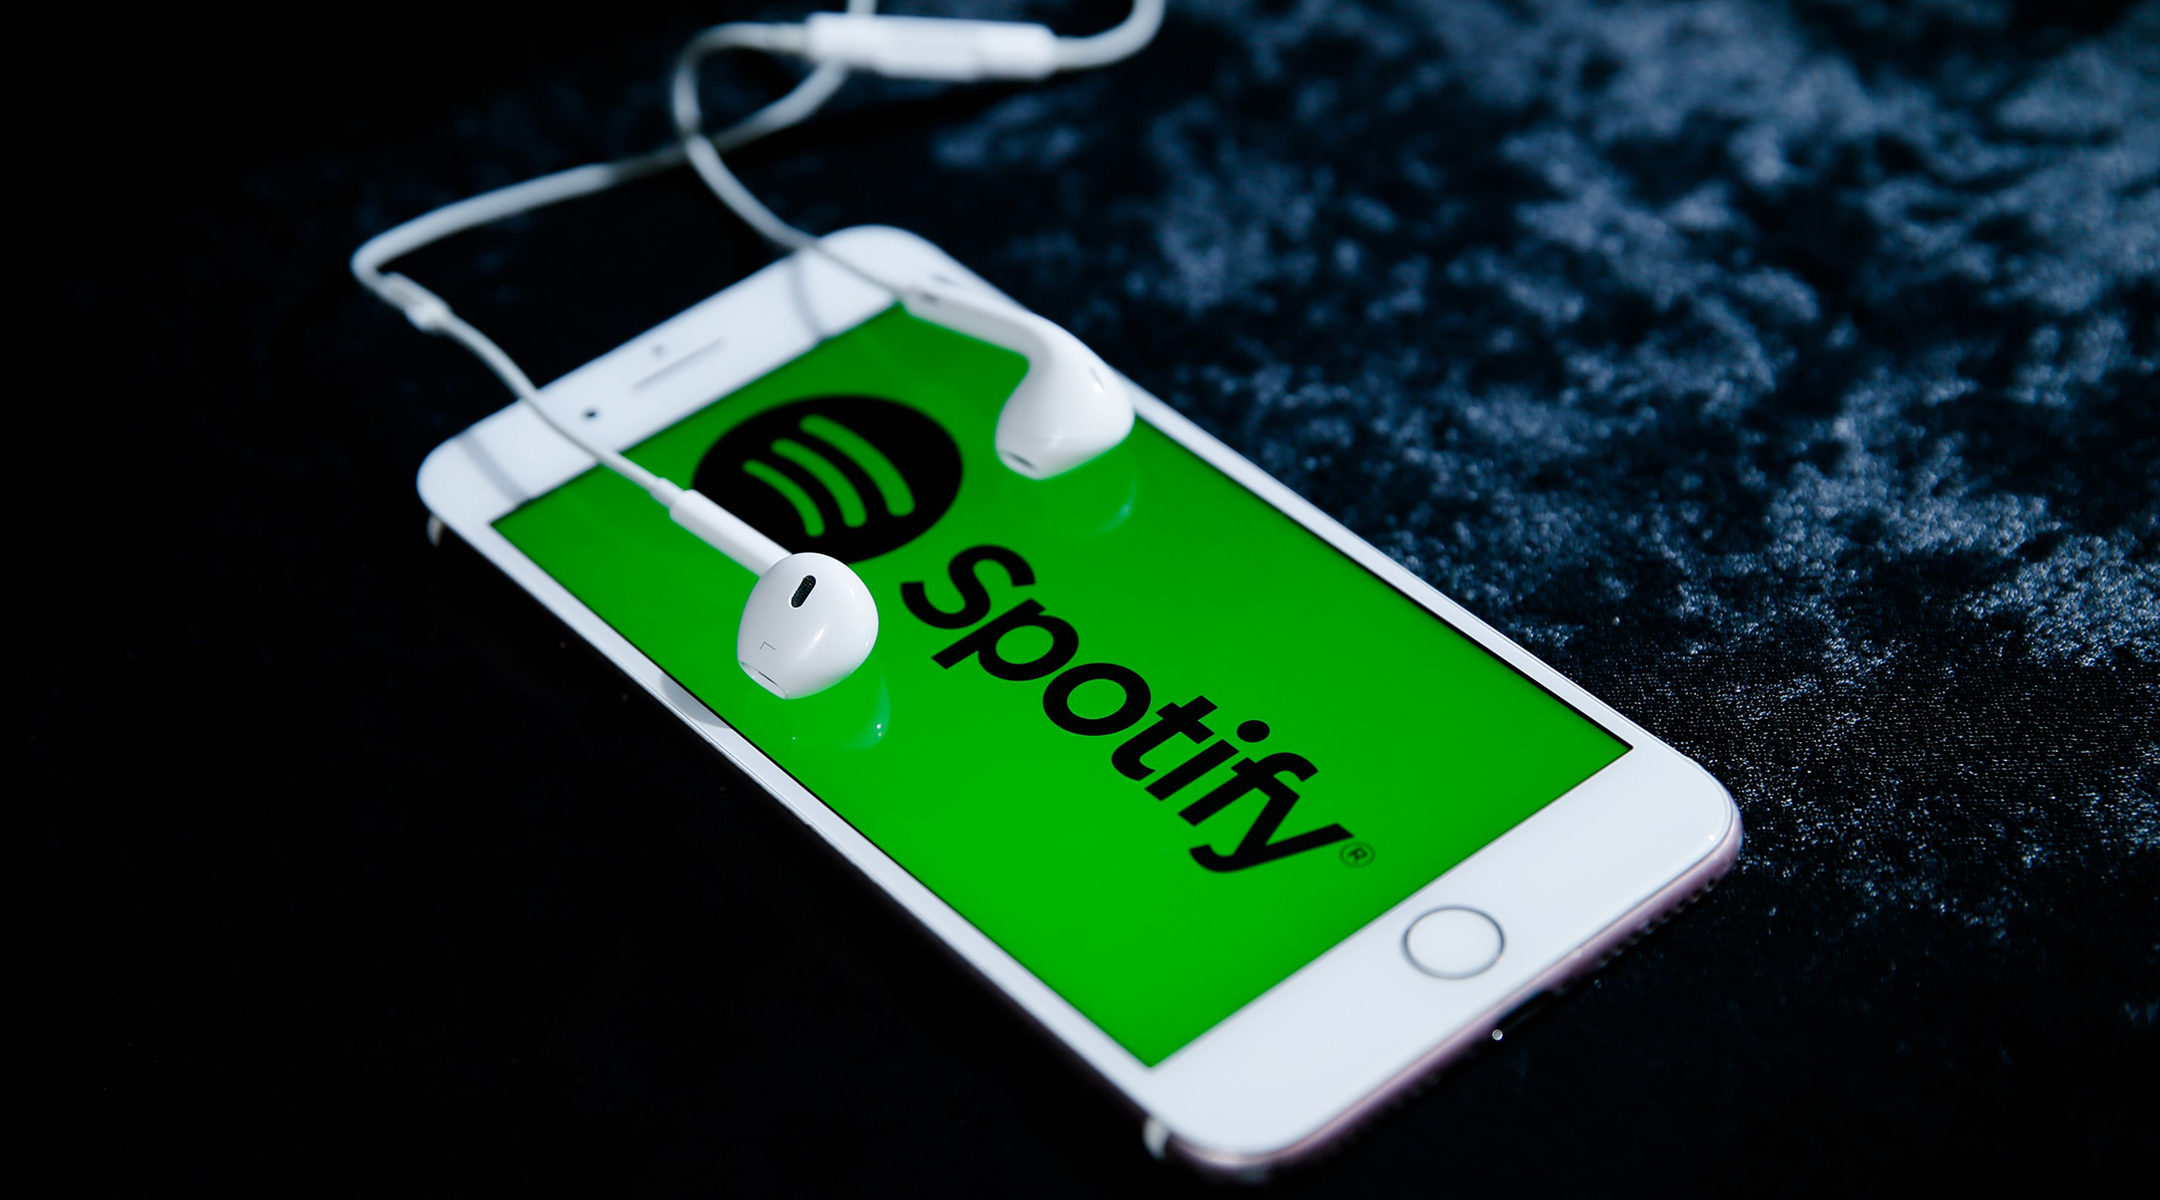

## Background

Spotify is a digital audio streaming platform that originated in Stockholm, Sweden. It has rapidly grown in popularity worldwide since it was founded in 2006. Spotify provides access to music, podcasts and video from record labels and media companies to consumers around the world! Users are able to browse a wide variety of tracks by artist, album, or genre and can create, edit and share playlists. 

## Loading the Data

The data for this project was sourced from kaggle: https://www.kaggle.com/leonardopena/top-spotify-songs-from-20102019-by-year

Our data utilizes the following attributes:

- ID
- Song Title
- Artist
- Genre of the Track
- Year Song was on Billboard
- BPM: Beats Per Minute (Tempo of the song)
- Energy of the song. The higher the value, the more energetic the song. 
- Danceability - The higher the value, the easier it is to dance to this song.
- dB - Loudness - The higher the value, the louder the song
- Live - The higher the value, the more likely the song is a live recording
- Valence - The higher the value, the more positive mood for the song.
- durLength - The duration of the song.
- Acousticness - The higher the value the more acoustic the song is.
- Speechiness - The higher the value the more spoken word the song contains.
- Popularity- The higher the value the more popular the song is.

You can read more in depth descriptions of the data attributes here: https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

In [92]:
import numpy as np 
import pandas as pd 
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install missingno
#!pip install wordcloud
import missingno as msno
from wordcloud import WordCloud
import sklearn
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB,BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

In [93]:
data = pd.read_csv("top-spotify-songs-from-20102019-by-year/top10s.csv", encoding='ISO-8859-1')
data.head()

Unnamed: 0                 title      artist        top genre  year  bpm  \
0           1      Hey, Soul Sister       Train       neo mellow  2010   97   
1           2  Love The Way You Lie      Eminem  detroit hip hop  2010   87   
2           3               TiK ToK       Kesha        dance pop  2010  120   
3           4           Bad Romance   Lady Gaga        dance pop  2010  119   
4           5  Just the Way You Are  Bruno Mars              pop  2010  109   

   nrgy  dnce  dB  live  val  dur  acous  spch  pop  
0    89    67  -4     8   80  217     19     4   83  
1    93    75  -5    52   64  263     24    23   82  
2    84    76  -3    29   71  200     10    14   80  
3    92    70  -4     8   71  295      0     4   79  
4    84    64  -5     9   43  221      2     4   78

In [94]:
# drop the unnamed column since it is not useful as index
data.drop("Unnamed: 0", axis=1, inplace=True)
data.head()

title      artist        top genre  year  bpm  nrgy  dnce  \
0      Hey, Soul Sister       Train       neo mellow  2010   97    89    67   
1  Love The Way You Lie      Eminem  detroit hip hop  2010   87    93    75   
2               TiK ToK       Kesha        dance pop  2010  120    84    76   
3           Bad Romance   Lady Gaga        dance pop  2010  119    92    70   
4  Just the Way You Are  Bruno Mars              pop  2010  109    84    64   

   dB  live  val  dur  acous  spch  pop  
0  -4     8   80  217     19     4   83  
1  -5    52   64  263     24    23   82  
2  -3    29   71  200     10    14   80  
3  -4     8   71  295      0     4   79  
4  -5     9   43  221      2     4   78

## Data Gathering

In [95]:
#!pip install spotipy

Client ID: 64cb58457d8a44e98b93b1761b82be6d
Client Secret: 03500ec43fef4db6933523d4d5b43304

URI: http://localhost:8888/callback

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

cid = '64cb58457d8a44e98b93b1761b82be6d'
secret = '03500ec43fef4db6933523d4d5b43304'
username = 'izzy730'

#for avaliable scopes see https://developer.spotify.com/web-api/using-scopes/
scope = 'user-library-read playlist-modify-public playlist-read-private'

redirect_uri='izzys-personal-playlist://callback'

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

token = util.prompt_for_user_token(username, scope, cid, secret, redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=64cb58457d8a44e98b93b1761b82be6d&response_type=code&redirect_uri=+&scope=playlist-modify-public+playlist-read-private+user-library-read in your browser


Enter the URL you were redirected to: 'izzys-personal-playlist://callback'




            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=64cb58457d8a44e98b93b1761b82be6d&response_type=code&redirect_uri=+&scop

In [53]:
import spotipy
import sys
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
cid = '64cb58457d8a44e98b93b1761b82be6d'
secret = '03500ec43fef4db6933523d4d5b43304'
username = 'izzy730'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
playlists = sp.user_playlists(username)

In [54]:
def get_playlist_tracks(username, playlist_id):
    tracks_list= []
    results = sp.user_playlist(username, playlist_id,
    fields="tracks,next")
    tracks = results['tracks']
    while tracks:
        tracks_list += [ item['track'] for (i, item) in
        enumerate(tracks['items']) ]
        tracks = sp.next(tracks)
    return tracks_list
def get_playlist_URIs(username, playlist_id):
    return [t["uri"] for t in get_playlist_tracks(username,
    playlist_id)]

In [55]:
bestofdecade_izzy = '37i9dQZF1DXaMu9xyX1HzK'
best_predf = get_playlist_tracks(username, bestofdecade_izzy)

In [56]:
best_df = pd.DataFrame(best_predf)
best_df.head()

album  \
0  {'album_type': 'compilation', 'artists': [{'ex...   
1  {'album_type': 'album', 'artists': [{'external...   
2  {'album_type': 'album', 'artists': [{'external...   
3  {'album_type': 'album', 'artists': [{'external...   
4  {'album_type': 'single', 'artists': [{'externa...   

                                             artists  \
0  [{'external_urls': {'spotify': 'https://open.s...   
1  [{'external_urls': {'spotify': 'https://open.s...   
2  [{'external_urls': {'spotify': 'https://open.s...   
3  [{'external_urls': {'spotify': 'https://open.s...   
4  [{'external_urls': {'spotify': 'https://open.s...   

                                   available_markets  disc_number  \
0  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...            1   
1  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...            1   
2  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...            1   
3  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...            1   
4  [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...            1   

   duration_ms  episode  explicit              external_ids  \
0       158040    False     False  {'isrc': 'USUM71814888'}   
1       197436    False     False  {'isrc': 'GBWWP1702907'}   
2       197866    False     False  {'isrc': 'GBAHS1900885'}   
3       181026    False     False  {'isrc': 'USUG11900515'}   
4       201660    False      True  {'isrc': 'USUM71813499'}   

                                       external_urls  \
0  {'spotify': 'https://open.spotify.com/track/3K...   
1  {'spotify': 'https://open.spotify.com/track/2P...   
2  {'spotify': 'https://open.spotify.com/track/70...   
3  {'spotify': 'https://open.spotify.com/track/22...   
4  {'spotify': 'https://open.spotify.com/track/5p...   

                                                href                      id  \
0  https://api.spotify.com/v1/tracks/3KkXRkHbMCAR...  3KkXRkHbMCARz0aVfEt68P   
1  https://api.spotify.com/v1/tracks/2P91MQbaiQOf...  2P91MQbaiQOfbiz9VqhqKQ   
2  https://api.spotify.com/v1/tracks/70eFcWOvlMOb...  70eFcWOvlMObDhURTqT4Fv   
3  https://api.spotify.com/v1/tracks/22vgEDb5hykf...  22vgEDb5hykfaTwLuskFGD   
4  https://api.spotify.com/v1/tracks/5p7ujcrUXASC...  5p7ujcrUXASCNwRaWNHR1C   

   is_local                                           name  popularity  \
0     False  Sunflower - Spider-Man: Into the Spider-Verse          86   
1     False                               I Like Me Better          77   
2     False                Beautiful People (feat. Khalid)          81   
3     False                                         Sucker          86   
4     False                                     Without Me          84   

                                         preview_url  track  track_number  \
0                                               None   True             2   
1  https://p.scdn.co/mp3-preview/fa069a3be2d69aab...   True             1   
2  https://p.scdn.co/mp3-preview/f94d8d0c1b37773f...   True             1   
3                                               None   True             1   
4                                               None   True             1   

    type                                   uri  
0  track  spotify:track:3KkXRkHbMCARz0aVfEt68P  
1  track  spotify:track:2P91MQbaiQOfbiz9VqhqKQ  
2  track  spotify:track:70eFcWOvlMObDhURTqT4Fv  
3  track  spotify:track:22vgEDb5hykfaTwLuskFGD  
4  track  spotify:track:5p7ujcrUXASCNwRaWNHR1C

In [57]:
#modified get features function
def get_audio_features (track_URIs) :
    features = []
    r = splitlist(track_URIs,50)
    for pack in range(len(r)):
        features = features + (sp.audio_features(r[pack]))
    df = pd.DataFrame.from_dict(features)
    df["uri"] = track_URIs
    return df

In [58]:
# create empty lists where the results are going to be stored
artist_name = []
track_name = []
popularity = []
track_id = []

for i in range(0,10000,50):
    track_results = sp.search(q='year: 2018', type='track', limit=50,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])
      

SpotifyException: http status: 404, code:-1 - https://api.spotify.com/v1/search?q=year%3A+2018&limit=50&offset=2000&type=track:
 Not found.

In [59]:
import pandas as pd

df_tracks = pd.DataFrame({'artist_name':artist_name,'track_name':track_name,'track_id':track_id,'popularity':popularity})
print(df_tracks.shape)
df_tracks.head()

(2000, 4)


artist_name                                     track_name  \
0  Trevor Daniel                                        Falling   
1     Juice WRLD                                   Lucid Dreams   
2     Juice WRLD                         All Girls Are The Same   
3  Billie Eilish                           lovely (with Khalid)   
4    Post Malone  Sunflower - Spider-Man: Into the Spider-Verse   

                 track_id  popularity  
0  4TnjEaWOeW0eKTKIEvJyCa          97  
1  285pBltuF7vW8TeWk8hdRR          89  
2  4VXIryQMWpIdGgYR4TrjT1          84  
3  0u2P5u6lvoDfwTYjAADbn4          89  
4  3KkXRkHbMCARz0aVfEt68P          86

In [ ]:
spotify_token = util.prompt_for_user_token(username,
                                           client_id=cid,
                                           client_secret=secret,
                                           redirect_uri="http://localhost:8888/callback")



            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/authorize?client_id=64cb58457d8a44e98b93b1761b82be6d&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%3A8888%2Fcallback in your browser


Enter the URL you were redirected to: https://accounts.spotify.com/authorize?client_id=64cb58457d8a44e98b93b1761b82be6d&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%3A8888%2Fcallback




            User authentication requires interaction with your
            web browser. Once you enter your credentials and
            give authorization, you will be redirected to
            a url.  Paste that url you were directed to to
            complete the authorization.

        
Opened https://accounts.spotify.com/aut

In [6]:
import requests
import csv
import time
import json
import sys
import imp
imp.reload(sys)

<module 'sys' (built-in)>

In [47]:
def main():
    
    queries = ['2000','2001','2002','2003','2004','2005','2006','2007','2008',
              '2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']
              
    # queries = ['2017']
    # Query and request from API are different!
    # Number of track query need to make
    num_tracks_per_query = 10000

    for query in queries:
        
        ltrack = []
        song_ids = []
        artist_ids = []
        album_ids = []
        
        audioF = []
        artist_data = []
        album_data = []

        
        col1 = [   'popularity',
                   'song_id',     'artist_id',     'album_id', 
                   'song_name',   'artist_name',   'album_name', 
                   'explicit',    'disc_number',   'track_number']
        
        
        col2 =  [  'song_id', 'uri',
                   'tempo', 'type',
                   'key', 'loudness',
                   'mode', 'speechiness',
                   'liveness', 'valence',
                   'danceability', 'energy',
                   'track_href', 'analysis_url',
                   'duration_ms', 'time_signature',
                   'acousticness', 'instrumentalness' ]
        
        col3 =  [  'artist_id',  'artist_genres',  'artist_popularity']
        
        col4 =  [  'album_id',  'album_genres',   'album_popularity',  'album_release_date']
        
        n = 0 
        idx = 0
        
        while idx < num_tracks_per_query:  
            
            API_search_request(query, 'track', 50, idx, ltrack, song_ids, artist_ids, album_ids)   
            n +=1
            print(('\n>> this is No '+ str(n) + ' search End '))
            idx += 50 
            # Limit API requests to at most 3ish calls / second
            time.sleep(0.3)                                     
        
        print(len(song_ids))
        ## spotify API "search" option vs here track/audiofeature query
        for idx in range(0, len(song_ids), 50):
            API_get_audio_feature(song_ids[idx: idx+50], audioF)
            time.sleep(0.3)
        
        for idx in range(0, len(artist_ids), 50):
            API_get_artists(artist_ids[idx: idx+50], artist_data)
            time.sleep(0.3)
        
        for idx in range(0, len(album_ids), 20):
            API_get_albums(album_ids[idx: idx+20], album_data)
            time.sleep(0.3)    
        
        
        df1 = pd.DataFrame(ltrack, columns=col1)
        
        df2 = pd.DataFrame(audioF, columns=col2) 
        
        
        df3 = pd.DataFrame(artist_data, columns=col3)
        
        df4 = pd.DataFrame(album_data, columns=col4)
        
        df = df1.merge(df2, on='song_id', how='outer').merge(df3, on='artist_id', how='outer').merge(
             df4, on='album_id', how='outer')
        
        filename = query + '.csv'                      
        
        df.to_csv(filename, sep='\t')
        
        print ('finish')
        print (query)

NameError: name 'query' is not defined

Spotify API: https://developer.spotify.com/documentation/web-api/reference/tracks/

In [ ]:
url = 'https://api.spotify.com/v1/search?q=year:'+ keywords +'&type=' + search_type +'&offset='+ off +'&limit=' + lim
requests.get(url).json()

In [ ]:
print('start..')


def main():
    
    queries = ['2000','2001','2002','2003','2004','2005','2006','2007','2008',
              '2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']
              
    # queries = ['2017']
    # Query and request from API are different!
    # Number of track query need to make
    num_tracks_per_query = 10000

    for query in queries:
        
        ltrack = []
        song_ids = []
        artist_ids = []
        album_ids = []
        
        audioF = []
        artist_data = []
        album_data = []

        
        col1 = [   'popularity',
                   'song_id',     'artist_id',     'album_id', 
                   'song_name',   'artist_name',   'album_name', 
                   'explicit',    'disc_number',   'track_number']
        
        
        col2 =  [  'song_id', 'uri',
                   'tempo', 'type',
                   'key', 'loudness',
                   'mode', 'speechiness',
                   'liveness', 'valence',
                   'danceability', 'energy',
                   'track_href', 'analysis_url',
                   'duration_ms', 'time_signature',
                   'acousticness', 'instrumentalness' ]
        
        col3 =  [  'artist_id',  'artist_genres',  'artist_popularity']
        
        col4 =  [  'album_id',  'album_genres',   'album_popularity',  'album_release_date']
        
        n = 0 
        idx = 0
        
        while idx < num_tracks_per_query:  
            
            API_search_request(query, 'track', 50, idx, ltrack, song_ids, artist_ids, album_ids)   
            n +=1
            print(('\n>> this is No '+ str(n) + ' search End '))
            idx += 50 
            # Limit API requests to at most 3ish calls / second
            time.sleep(0.3)                                     
        
        print(len(song_ids))
        ## spotify API "search" option vs here track/audiofeature query
        for idx in range(0, len(song_ids), 50):
            API_get_audio_feature(song_ids[idx: idx+50], audioF)
            time.sleep(0.3)
        
        for idx in range(0, len(artist_ids), 50):
            API_get_artists(artist_ids[idx: idx+50], artist_data)
            time.sleep(0.3)
        
        for idx in range(0, len(album_ids), 20):
            API_get_albums(album_ids[idx: idx+20], album_data)
            time.sleep(0.3)    
        
        
        df1 = pd.DataFrame(ltrack, columns=col1)
        
        df2 = pd.DataFrame(audioF, columns=col2) 
        
        
        df3 = pd.DataFrame(artist_data, columns=col3)
        
        df4 = pd.DataFrame(album_data, columns=col4)
        
        df = df1.merge(df2, on='song_id', how='outer').merge(df3, on='artist_id', how='outer').merge(
             df4, on='album_id', how='outer')
        
        filename = query + '.csv'                      
        
        df.to_csv(filename, sep='\t')
        
        print ('finish')
        print (query)

def API_search_request(keywords, search_type, results_limit, results_offset, ltrack, song_ids, artist_ids, album_ids):

    off = str(results_offset)
    lim = str(results_limit)

    url = 'https://api.spotify.com/v1/search?q=year:'+ keywords +'&type=' + search_type +'&offset='+ off +'&limit=' + lim

    r = requests.get(url)

    if r: 
        j = r.json()
    else:
        return r


    litem = j['tracks']['items']
    #print(len(ll))
    try:
        for l in litem:
        
            if l['id'] not in song_ids:
                song_ids.append( l['id'] )

            if l['artists'][0]['id'] not in artist_ids:
                artist_ids.append( l['artists'][0]['id'] )

            if l['album']['id'] not in album_ids:
                album_ids.append(  l['album']['id'] )
        
        
            k =   [  l['popularity'],
        
                     l['id'], 
                     l['artists'][0]['id'],
                     l['album']['id'],

                     l['name'],
                     l['artists'][0]['name'],
                     l['album']['name'],

                     l['explicit'], 
                     l['disc_number'],
                     l['track_number']]
        
            ltrack.append(k)
    except:
         ValueError
      
   # f.close()
    #return j


def API_get_audio_feature(songids, audioF):
    
    #print(songids)
    #print '>> call art several'
    track_ids = ','.join(songids)

    url = 'https://api.spotify.com/v1/audio-features?ids=' + track_ids  
    ## access_token will expire soon
    access_token = (  'Bearer BQDAZNalQ6KCd8pRM0Exu3D-tzdeodFYL86pdq8kz'
                      'qN8i5gqeLMNeCgyPmZ1B3mgQ2YGd29tL06jxeNzOMkhmi4GM'
                      'QQLQ_ZfQUroBMRSMj10IOjEo-cX7YsfzH_v3eUlN4wXgDd4z'
                      'njNqrPu-MI9qRz3_jyb44urQ7J5TeOeWk4kvHKfD36TplacQ'
                      'DeYJe49DsaAQWuCSe5kdt1r7r0GqugSH85vOaa5qrqMaGbKM'
                      'DnZ-2aWzuLUE37Vh3U2MR3VEdgHPIxlQtC_vfTBwiMZZcY55'
                      'Q1aZuKSrGL9A6MC2hUi4CgRMD1mXwE9l8bLJQ')
    
    
    r = requests.get(url, headers={"Accept": "application/json" , "Authorization": access_token})
    
    if r: 
        j = r.json()
    else:
        return r
    
    # print(j)
    ll = j['audio_features']

    try:

        for l in ll:
            k =  [  l['id'],l['uri'],
                    l['tempo'],l['type'],
                    l['key'],l['loudness'],
                    l['mode'],l['speechiness'],
                    l['liveness'],l['valence'],
                    l['danceability'],l['energy'],
                    l['track_href'],l['analysis_url'],
                    l['duration_ms'],l['time_signature'],
                    l['acousticness'],l['instrumentalness'] ]

            audioF.append(k)
        
    except:
        ValueError
    
        

    #return j

def API_get_artists(artist_ids, artist_data):

    art_ids = ','.join(artist_ids)

    url = 'https://api.spotify.com/v1/artists?ids=' + art_ids

    r = requests.get(url)

    if r:
        j = r.json()
    else:
       #print 'for this specific art_ids, response reaches maximum, return'
       return r

    
    ll = j['artists']

    try:
        for l in ll:
        
            k = [  l['id'], 
                   l['genres'],
                   l['popularity'] ]

            artist_data.append(k)
    
    except:
        ValueError
    


def API_get_albums(album_ids, album_data):
   

    alb_ids = ','.join(album_ids)

    url = 'https://api.spotify.com/v1/albums?ids=' + alb_ids
    r = requests.get(url)

    if r:
       j = r.json()
    else:
        return r


    ll = j['albums']
    
    try:
        for l in ll:
            k = [  l['id'], 
                   l['genres'],
                   l['popularity'],
                   l['release_date'] ]

            album_data.append(k)
    
    except:
        ValueError


if __name__ == '__main__':
    main()

## Data Preprocessing

In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603 entries, 0 to 602
Data columns (total 14 columns):
track               603 non-null object
artist              603 non-null object
top_genre           603 non-null object
year                603 non-null int64
beats_per_minute    603 non-null int64
energy              603 non-null int64
danceability        603 non-null int64
loudness(dB)        603 non-null int64
liveness            603 non-null int64
valence             603 non-null int64
length              603 non-null int64
acousticness        603 non-null int64
speechiness         603 non-null int64
popularity          603 non-null int64
dtypes: int64(11), object(3)
memory usage: 66.0+ KB


We can see that title, artist, and genre are categorical variables and the rest are numerical. All variables have the same amount of entries so there are no missing values.  

In [102]:
# Renaming few columns to make more sense

data.rename(columns = {'title': 'track','top genre': 'top_genre', 'bpm': 'beats_per_minute', 'nrgy': 'energy', 
                       'dnce': 'danceability', 'dB': 'loudness(dB)', 'live': 'liveness', 
                       'val': 'valence', 'dur': 'length', 'acous': 'acousticness', 
                       'spch': 'speechiness', 'pop': 'popularity'}, inplace=True)
data.head()

track      artist        top_genre  year  beats_per_minute  \
0      Hey, Soul Sister       Train       neo mellow  2010                97   
1  Love The Way You Lie      Eminem  detroit hip hop  2010                87   
2               TiK ToK       Kesha        dance pop  2010               120   
3           Bad Romance   Lady Gaga        dance pop  2010               119   
4  Just the Way You Are  Bruno Mars              pop  2010               109   

   energy  danceability  loudness(dB)  liveness  valence  length  \
0      89            67            -4         8       80     217   
1      93            75            -5        52       64     263   
2      84            76            -3        29       71     200   
3      92            70            -4         8       71     295   
4      84            64            -5         9       43     221   

   acousticness  speechiness  popularity  
0            19            4          83  
1            24           23          82  
2            10           14          80  
3             0            4          79  
4             2            4          78

In [103]:
#sanity check that we aren't missing any values
data.isnull().sum()

track               0
artist              0
top_genre           0
year                0
beats_per_minute    0
energy              0
danceability        0
loudness(dB)        0
liveness            0
valence             0
length              0
acousticness        0
speechiness         0
popularity          0
dtype: int64

In [110]:
# are there any null values?
data.isnull().values.any()

False

Let's have a general overview of our data to see if the values look ok.

In [111]:
data.describe()

year  beats_per_minute      energy  danceability  loudness(dB)  \
count   603.000000        603.000000  603.000000    603.000000    603.000000   
mean   2014.592040        118.545605   70.504146     64.379768     -5.578773   
std       2.607057         24.795358   16.310664     13.378718      2.798020   
min    2010.000000          0.000000    0.000000      0.000000    -60.000000   
25%    2013.000000        100.000000   61.000000     57.000000     -6.000000   
50%    2015.000000        120.000000   74.000000     66.000000     -5.000000   
75%    2017.000000        129.000000   82.000000     73.000000     -4.000000   
max    2019.000000        206.000000   98.000000     97.000000     -2.000000   

         liveness     valence      length  acousticness  speechiness  \
count  603.000000  603.000000  603.000000    603.000000   603.000000   
mean    17.774461   52.225539  224.674959     14.326700     8.358209   
std     13.102543   22.513020   34.130059     20.766165     7.483162   
min      0.000000    0.000000  134.000000      0.000000     0.000000   
25%      9.000000   35.000000  202.000000      2.000000     4.000000   
50%     12.000000   52.000000  221.000000      6.000000     5.000000   
75%     24.000000   69.000000  239.500000     17.000000     9.000000   
max     74.000000   98.000000  424.000000     99.000000    48.000000   

       popularity  
count  603.000000  
mean    66.520730  
std     14.517746  
min      0.000000  
25%     60.000000  
50%     69.000000  
75%     76.000000  
max     99.000000

We can see that the min beats_per_minute is 0, which seems to be an error since a song wouldn't have 0 beats. Let's have a look at our mean, median, and std and see the distribution of our values to determine what we should use to substitute in for our zero values. We will do the same for valence and popularity

mean      118.545605
median    120.000000
std        24.795358
Name: beats_per_minute, dtype: float64


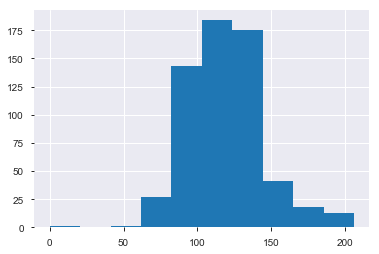

In [112]:
print(data.beats_per_minute.apply(['mean', 'median', 'std'])) 
data.beats_per_minute.hist();

We can see that zero is an outlier. We will substitute the mean for zero values to reduce bias in our data. 

In [119]:
data.beats_per_minute = data.beats_per_minute.replace(0, data.beats_per_minute.mean())

In [120]:
data.beats_per_minute.describe()

count    603.000000
mean     118.742198
std       24.319275
min       43.000000
25%      100.000000
50%      120.000000
75%      129.000000
max      206.000000
Name: beats_per_minute, dtype: float64

mean      70.504146
median    74.000000
std       16.310664
Name: energy, dtype: float64


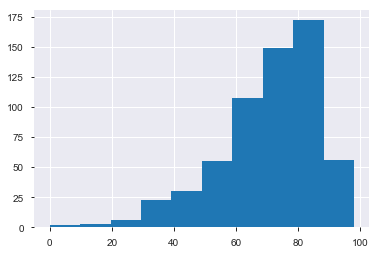

In [121]:
print(data.energy.apply(['mean', 'median', 'std'])) 
data.energy.hist();

In [122]:
data.energy = data.energy.replace(0, data.energy.mean())

In [123]:
data.energy.describe()

count    603.000000
mean      70.621068
std       16.055120
min        4.000000
25%       61.000000
50%       74.000000
75%       82.000000
max       98.000000
Name: energy, dtype: float64

In [ ]:
print(data['track'].value_counts().head(20))

In [ ]:
data[data.track == 'Just the Way You Are']

We can see that some of the tracks are counted twice since they cover two different years. Let's remove the duplicate values. 

In [89]:
duplicates = data[data.duplicated(subset=['track','artist'])]
print(len(duplicates))

16


In [90]:
data.drop_duplicates(subset=['track','artist'], keep='first', inplace=True)

In [91]:
data['track'].value_counts().head(20)

I Like It                          2
Hello                              2
Say Something                      2
Come Get It Bae                    1
Uptown Funk                        1
Monster                            1
Sheezus                            1
I Want You To Know                 1
Dance Again                        1
Paradise                           1
Die Young                          1
Bloodstream                        1
California Gurls                   1
Someone Like You                   1
Lust for Life (with The Weeknd)    1
Locked Out of Heaven               1
Confident                          1
Blah Blah Blah (feat. 3OH!3)       1
Love                               1
Baby                               1
Name: track, dtype: int64

In [ ]:
data['top_genre'].value_counts()

We can see that there are many different variations of 'pop'

## Exploratory Data Analysis

Brief overview:

In [8]:
data.shape

(603, 14)

In [9]:
data.describe()

year  beats_per_minute      energy  danceability  loudness(dB)  \
count   603.000000        603.000000  603.000000    603.000000    603.000000   
mean   2014.592040        118.545605   70.504146     64.379768     -5.578773   
std       2.607057         24.795358   16.310664     13.378718      2.798020   
min    2010.000000          0.000000    0.000000      0.000000    -60.000000   
25%    2013.000000        100.000000   61.000000     57.000000     -6.000000   
50%    2015.000000        120.000000   74.000000     66.000000     -5.000000   
75%    2017.000000        129.000000   82.000000     73.000000     -4.000000   
max    2019.000000        206.000000   98.000000     97.000000     -2.000000   

         liveness     valence      length  acousticness  speechiness  \
count  603.000000  603.000000  603.000000    603.000000   603.000000   
mean    17.774461   52.225539  224.674959     14.326700     8.358209   
std     13.102543   22.513020   34.130059     20.766165     7.483162   
min      0.000000    0.000000  134.000000      0.000000     0.000000   
25%      9.000000   35.000000  202.000000      2.000000     4.000000   
50%     12.000000   52.000000  221.000000      6.000000     5.000000   
75%     24.000000   69.000000  239.500000     17.000000     9.000000   
max     74.000000   98.000000  424.000000     99.000000    48.000000   

       popularity  
count  603.000000  
mean    66.520730  
std     14.517746  
min      0.000000  
25%     60.000000  
50%     69.000000  
75%     76.000000  
max     99.000000

In [10]:
import pandas_profiling
from pandas_profiling import ProfileReport

profile = pandas_profiling.ProfileReport(data)
profile

Observations: <br/>
- There are 11 numberical categories and 3 categorical categories
- The numerical values are highly skewed and will need to be standardized

Let's break down the songs by genre type to get an idea of what kinds of genres were popular from 2010-2019.

In [11]:
print(type(data['top_genre']))
popular_genre=data.groupby('top_genre').size()
print(popular_genre)
genre_list=data['top_genre'].values.tolist()

<class 'pandas.core.series.Series'>
top_genre
acoustic pop                   2
alaska indie                   1
alternative r&b                1
art pop                        8
atl hip hop                    5
australian dance               6
australian hip hop             1
australian pop                 5
barbadian pop                 15
baroque pop                    2
belgian edm                    2
big room                      10
boy band                      15
british soul                  11
brostep                        2
canadian contemporary r&b      9
canadian hip hop               2
canadian latin                 1
canadian pop                  34
candy pop                      2
celtic rock                    1
chicago rap                    1
colombian pop                  3
complextro                     6
contemporary country           1
dance pop                    327
danish pop                     1
detroit hip hop                2
downtempo                     

In [12]:
#Calculating the number of songs by each of the artists
print(data.groupby('artist').size())
popular_artist=data.groupby('artist').size()
print(popular_artist)
artist_list=data['artist'].values.tolist()

artist
3OH!3                        1
5 Seconds of Summer          1
A Great Big World            1
Adam Lambert                 2
Adele                       10
Alan Walker                  1
Alessia Cara                 4
Alesso                       1
Alicia Keys                  6
Ansel Elgort                 1
Ariana Grande                9
Austin Mahone                2
Avicii                       3
Avril Lavigne                2
Bastille                     1
Bebe Rexha                   2
Beyoncé                      8
Birdy                        5
Britney Spears               9
Bruno Mars                  13
BØRNS                        1
CNCO                         1
Calvin Harris               10
Camila Cabello               3
Cardi B                      3
Carly Rae Jepsen             5
Cashmere Cat                 2
Charli XCX                   1
Charlie Puth                 3
Chris Brown                  3
                            ..
Selena Gomez                 8
S

In [50]:
print(data['year'].value_counts().head())

2015    95
2016    80
2013    71
2017    65
2018    64
Name: year, dtype: int64


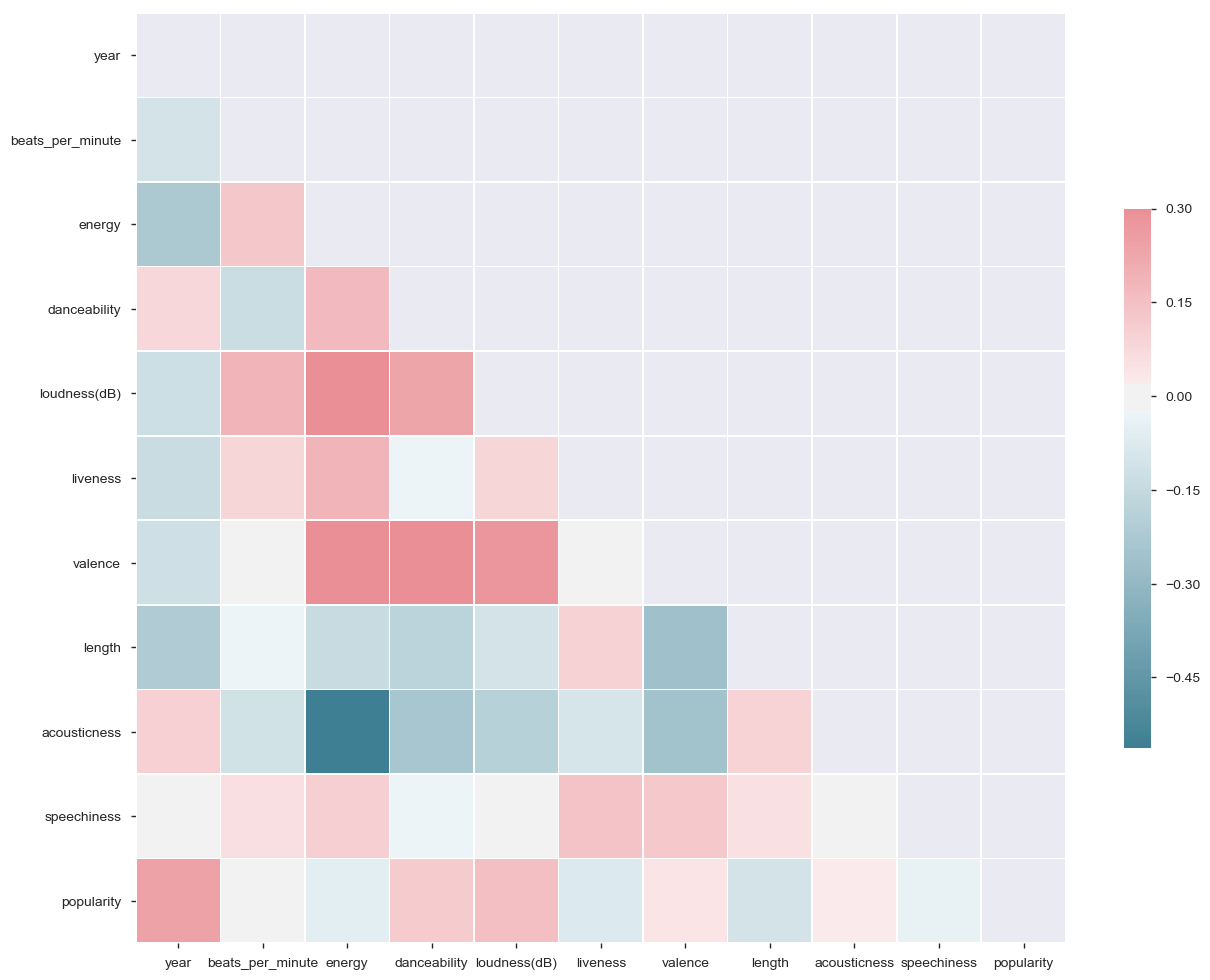

In [13]:
corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15, 14))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

- There is high positive correlation between popularity and year, valence and energy, valence and danceability, and valence and loudness. To address this in the future, we may need to remove valence as a variable.
- There is high negative correlation between acousticness and energy

Let's have a look at the relationships between some of our numerical values: <br/>

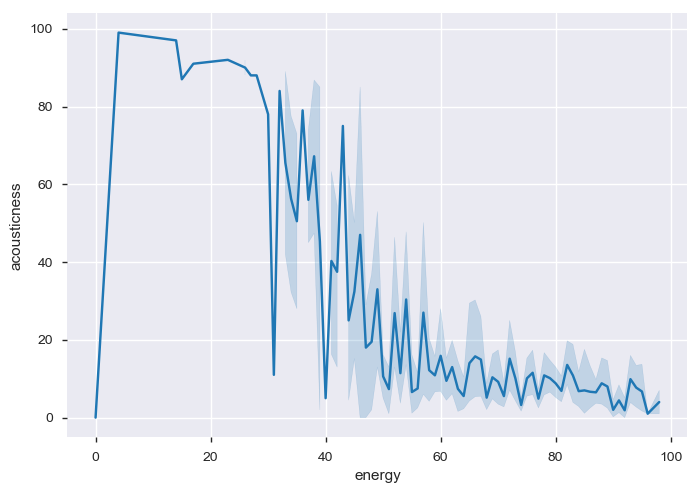

In [14]:
sns.lineplot(x="energy", y="acousticness", data=data);

Acousticness and energy seem to have an inverse relationship where the energy tends to be lower with a higher acoustic score and vice versa. This makes sense since acoustic songs tend to be more intimate. <br/>
<br/>
On the other hand, live shows tend to have a lot of energy and are louder. Let's visualize the relationship between liveness and loudness for the tracks in this dataset.

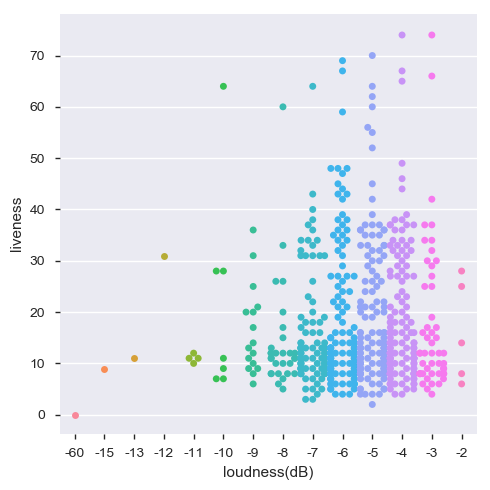

In [43]:
sns.catplot(y="liveness", x="loudness(dB)", kind="swarm", data=data);

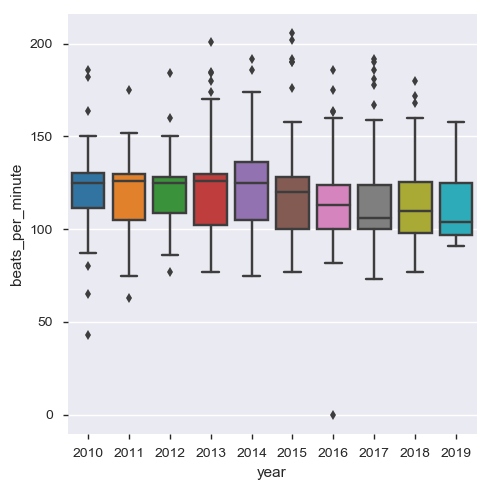

In [16]:
sns.catplot(y="beats_per_minute", x="year", kind="box", data=data)

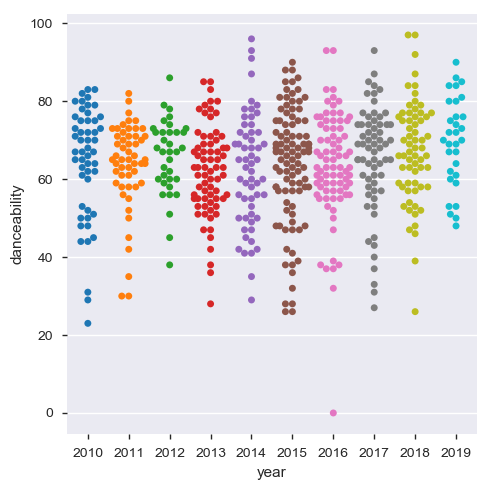

In [18]:
sns.catplot(y="danceability", x="year", kind="swarm", data=data)

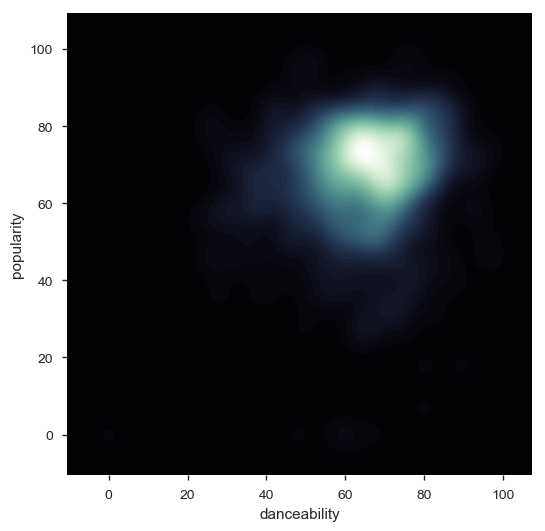

In [20]:
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.cubehelix_palette(rot=-.4, as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(data.danceability, data.popularity, cmap=cmap, n_levels=60, shade=True);

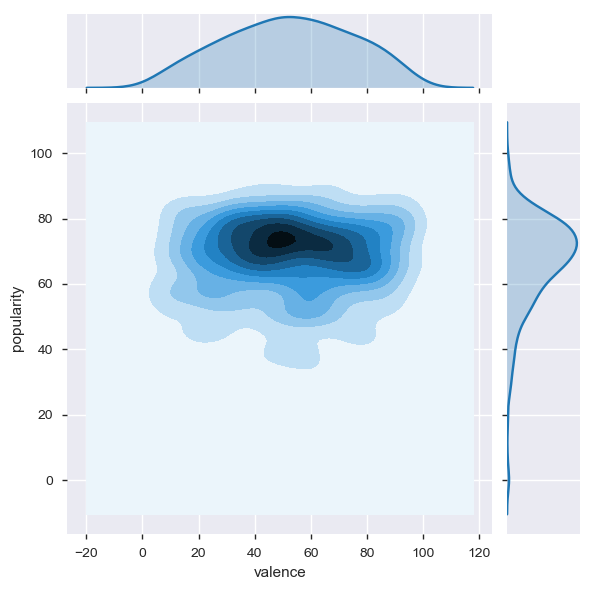

In [26]:
sns.jointplot(x=data.valence, y=data.popularity, data=data, kind="kde");

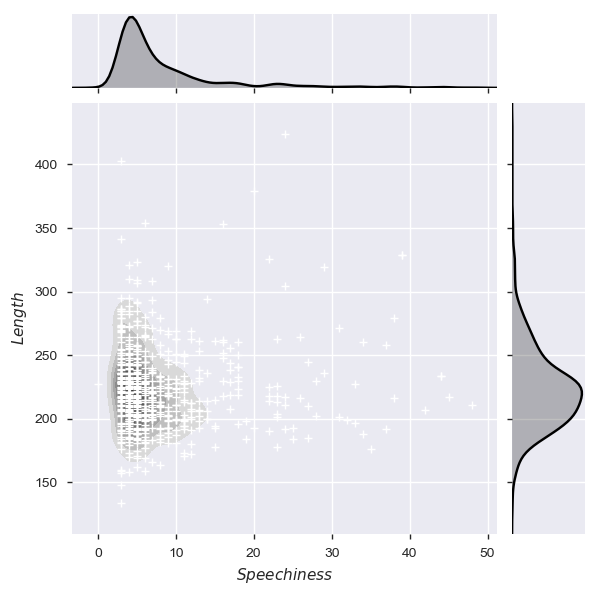

In [27]:
g = sns.jointplot(x=data.speechiness, y=data.length, data=data, kind="kde", color="k")
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$Speechiness$", "$Length$")

Now let's have a look at our categorical data:

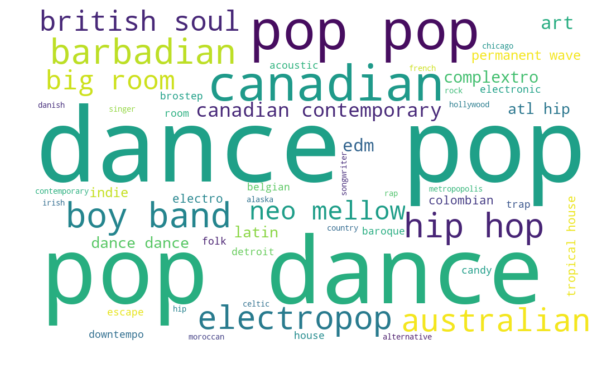

In [32]:
Sptfy_wordcloud = WordCloud(width = 1000, height = 600, max_font_size = 200, max_words = 150,
                      background_color='white').generate(" ".join(data.top_genre))

plt.figure(figsize=[10,10])
plt.imshow(Sptfy_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [65]:
print(data['top_genre'].value_counts().head(15))

dance pop                    327
pop                           60
canadian pop                  34
boy band                      15
barbadian pop                 15
electropop                    13
british soul                  11
big room                      10
canadian contemporary r&b      9
neo mellow                     9
art pop                        8
hip pop                        6
complextro                     6
australian dance               6
atl hip hop                    5
Name: top_genre, dtype: int64


In [66]:
for i in data['top_genre']:
    if 'pop' in i:
        data['top_genre'] = data['top_genre'].replace(i, 'pop')
        
    elif 'hip hop' in i:
        data['top_genre'] = data['top_genre'].replace(i, 'hip hop')

    elif 'edm' in i:
        data['top_genre'] = data['top_genre'].replace(i, 'edm')

    elif 'r&b' in i:
        data['top_genre'] = data['top_genre'].replace(i, 'pop')

    elif 'latin' in i:
        data['top_genre'] = data['top_genre'].replace(i, 'latin')

    elif 'room' in i:
        data['top_genre'] = data['top_genre'].replace(i, 'room')

    elif 'electro' in i:
        data['top_genre'] = data['top_genre'].replace(i, 'edm')
        
data['top_genre'] = data['top_genre'].replace('chicago rap', 'hip hop')
        
data['top_genre']

0      neo mellow
1         hip hop
2             pop
3             pop
4             pop
5             pop
6             pop
7             pop
8             pop
9             pop
10            pop
11            pop
12            pop
13            pop
14            pop
15        hip hop
16            pop
17            pop
18            pop
19            pop
20            pop
21            pop
22            pop
23            pop
24            pop
25            pop
26            pop
27            pop
28            pop
29            pop
          ...    
573           pop
574           pop
575           pop
576           pop
577           pop
578           pop
579       brostep
580          room
581          room
582           edm
583      boy band
584           pop
585      boy band
586           pop
587           pop
588           pop
589           pop
590           pop
591          room
592           pop
593           pop
594           pop
595           pop
596           edm
597       

In [67]:
print(data['top_genre'].value_counts().head())

pop         495
boy band     15
hip hop      15
edm          12
room         12
Name: top_genre, dtype: int64


Pop and dance seem to be the top genres. Let's get the actual value counts for these groups.

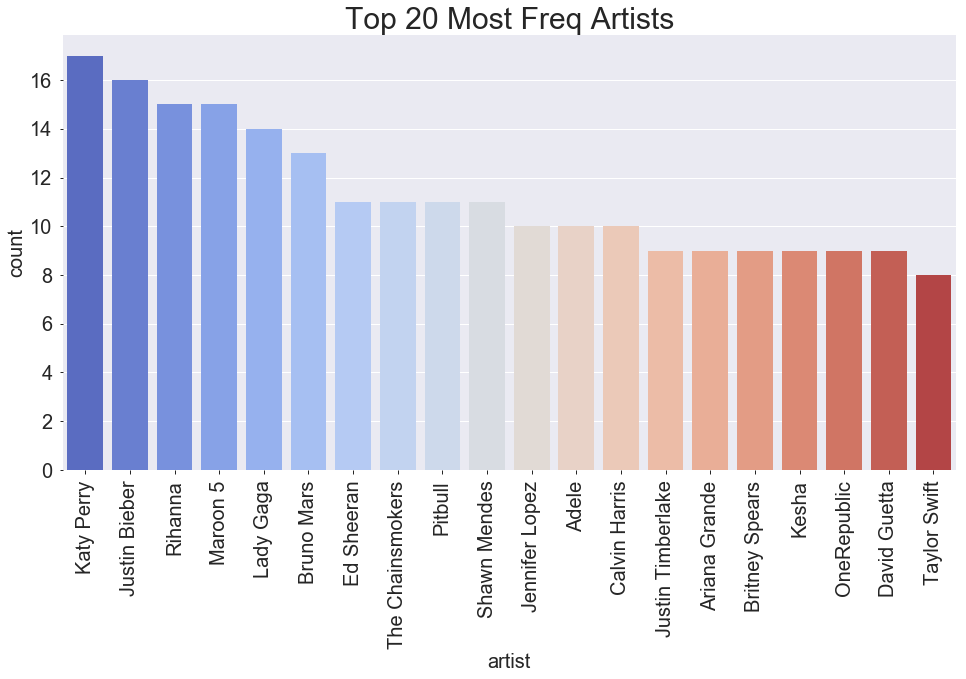

In [41]:
plt.figure(figsize=(16,8))
plt.title('Top 20 Most Freq Artists',fontsize=30)
plt.xlabel('Artist', fontsize=20)
plt.ylabel('Count', fontsize=20)

sns.countplot(data.artist,order=pd.value_counts(data.artist).iloc[:20].index,palette=sns.color_palette("coolwarm", 20))

plt.xticks(size=20,rotation=90)
plt.yticks(size=20)
sns.despine(bottom=True, left=True)
plt.show()

## Hypothesis Testing

## Time Series

## Creating a Playlist

## Predicting Hit Songs

## Song Recommendations